# レポート課題3

## 特異値分解

特異値分解（singular value decomposition）について調べて説明せよ．さらに，主成分分析と特異値分解との違いや関連性について説明せよ．

特異値分解(Singular Value Decomposition)は$n \times p$行列$X$を
\begin{align}
    X &= U\Lambda V^T\\
        &=  
        (\boldsymbol{u}_1, \boldsymbol{u}_2, \cdots, \boldsymbol{u}_p)
        \begin{pmatrix}
            \sqrt{\lambda_1} &          &        &          \\
            & \sqrt{\lambda_2} &        &          \\
            &          & \ddots &          \\
            &          &        & \sqrt{\lambda_p}
        \end{pmatrix}
        \begin{pmatrix}
            \boldsymbol{v}_1^{\mathrm{T}} \\
            \boldsymbol{v}_2^{\mathrm{T}} \\
            \vdots \\
            \boldsymbol{v}_p^{\mathrm{T}}
        \end{pmatrix}
\end{align}
のように分解することができる．

ここで，$U$は$XX^T$の非ゼロ固有値に対応する固有値ベクトルからなる$n \times p$列正規直交行列，

$V$は$X^TX$の非ゼロ固有値に対応する固有値ベクトルからなる$p \times p$列正規直交行列，

$\Lambda$は$XX^T$あるいは$X^TX$の固有値の平方根（特異値）を大きい順に対角上に並べたものである

このとき，固有値の大きい順に，その固有ベクトルが元の行列において重要であることを意味するので，削減したい列分だけ選択することで，元の行列をよく反映した行列に変換することができる．

$p$次元の特徴量のうち，$k$次元だけ選択したいときは$XV^k$とすればよい($V^k$は固有値の大きい順に固有ベクトルを$k$だけ選んだ行列である)

主成分分析は，射影された点の分散を最大化するような軸を求める．特異値分解は，$X$が$p$個の特徴量を持つ$n$個のデータとして，平均ベクトルが0になるように変換されたものだった場合，$X^TX$はその共分散行列であることを意味し，その固有値と固有ベクトルが$\lambda_i$や$v_i$になっているという点で，非常に関連している．

主成分分析は目的関数を最大化して次元削減するが，特異値分解は固有値分解した結果を表現したものを利用する形で次元削減するので，アプローチが異なっている．

参考文献
- はじめてのパターン認識, 平井有三, 森北出版株式会社, 2012

## 主成分分析

任意のデータを選び，主成分分析を行った結果をまとめよ．ただし，以下の事柄は必ずレポートに含めるようにせよ．また，分析に用いたプログラムもJupyter Notebookにまとめよ．

+ 選んだデータの説明（提供者，内容，データのサイズなど）
+ 累積寄与率のグラフ
+ 第一主成分と第二主成分のベクトル
+ 主成分分析から分かったこと

レポート1，2で使った[livedoor ニュースコーパス](https://www.rondhuit.com/download.html)を用いる．

このとき，レポート1,2で用いた記事を単語ベクトルに変換する手法を用いてベクトル表現にしたものを用いて主成分分析を行う

提供：NHN Japan株式会社

内容：ニュース記事の分類

データサイズ：9つの記事への分類，7376の記事，ベクトル変換後の単語ベクトルの大きさ：27073

In [7]:
import pathlib

D = []
p = pathlib.Path('text')
for d in p.iterdir():
    if not d.is_dir():
        continue
    source = d.name
    for fname in d.glob('*.txt'):
        with open(fname) as fi:
            url = fi.readline().strip()
            timestamp = fi.readline().strip()
            title = fi.readline().strip()
            text = [line.strip() for line in fi if line.strip()]
            D.append(
                dict(source=source, url=url, timestamp=timestamp, title=title, text=text)
                )

In [11]:
import MeCab
tagger = MeCab.Tagger('-Owakati')

# mecab-ipadic-neologdを使っても性能が出なかった
# neologd = MeCab.Tagger('-d /usr/lib/mecab/dic/mecab-ipadic-neologd')
# neologd.parse('') 

def tokenize(s):
    return tagger.parse(s).split()

def token2vec(token):
    vec = defaultdict(int)
    for sentence in token:
        for word in sentence:
                vec[word] += 1
    return vec

In [10]:

import numpy as np
import re

import neologdn


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

In [12]:
# 前回の流用
urlre=re.compile(r'(http|https)://([-\w]+\.)+[-\w]+(/[-\w./?%&=]*)?')
symbolre = re.compile('[，．、。]')
# numre = re.compile(r'\d+')

def mytokenize(d):
    s=''.join(d)
    token = []
    s=s.replace('\u3000','')
    neologdn.normalize(s)
    s=urlre.sub("", s)
    s=symbolre.sub(" ", s)
#     s=numre.sub('0', s)
    node = tagger.parseToNode(s)
    while node:
        features = node.feature.split(',')
        pos = features[0]
#         pos_sub1 = features[1]
        base = features[6]
        if node.surface == '':
            node = node.next
            continue
        if pos in ['名詞', '動詞', '形容詞', '連体詞', '副詞', '感動詞', '記号']: # and pos_sub1 not in  ['非自立', '接尾']:
            if base == "*":
                token.append(node.surface)
            else:
                token.append(base)

        node = node.next

    return token

In [13]:
vectorizer = TfidfVectorizer(analyzer=mytokenize,min_df=3, max_df=0.7, norm='l2', sublinear_tf=True)
vectorizer.fit([[d['title']]+d['text'] for d in Dtrain])

# 用いるデータ
# titleとtextを結合してベクトル化
X = vectorizer.transform([[d['title']]+ d['text'] for d in D]).toarray()

VY = preprocessing.LabelEncoder()
Y = VY.fit_transform([data['source'] for data in D])

In [17]:
from sklearn.decomposition import PCA

pca = PCA(2)
P = pca.fit_transform(X)

In [19]:
import matplotlib.pyplot as plt

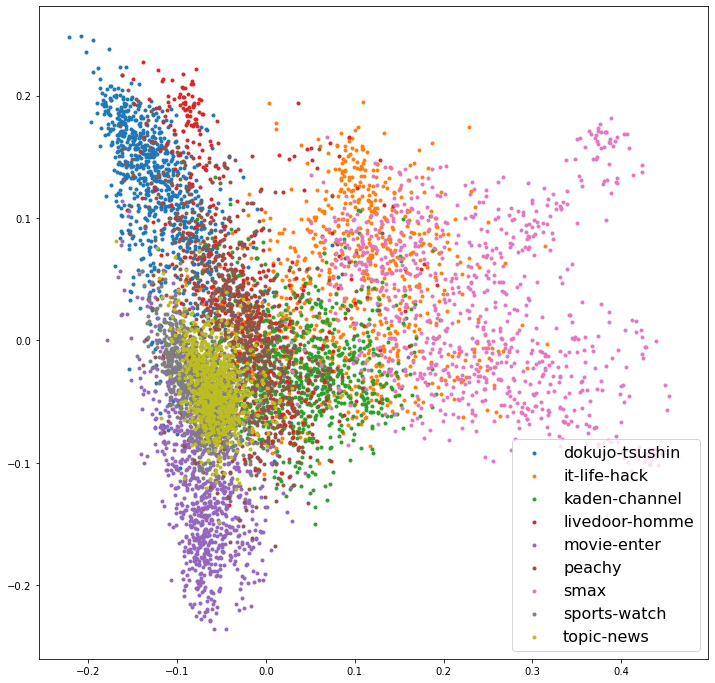

In [20]:
plt.figure(figsize=(12, 12))
for i in np.unique(Y):
    cluster=np.where(Y==i)[0]
    plt.scatter(P[cluster, 0], P[cluster, 1], c=f'C{i}', label=VY.classes_[i], marker='.')
plt.legend(fontsize=16)
plt.show()

# 累積寄与率

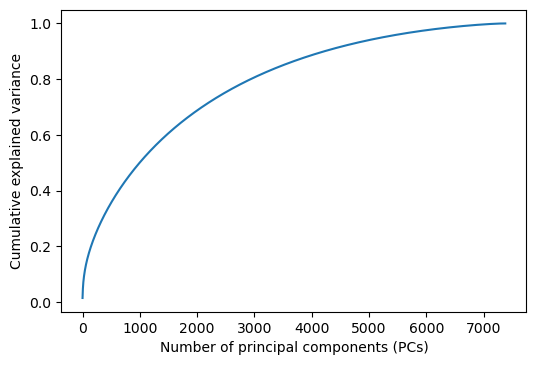

In [25]:
pca = PCA(7376)
pca.fit(X)

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)

ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel('Number of principal components (PCs)')
ax.set_ylabel('Cumulative explained variance')
plt.show()

第一主成分と第二主成分のベクトルについての分析を行う

In [29]:
pca = PCA(2)
P = pca.fit_transform(X)

In [104]:
# 固有値は第一主成分のほうが大きい
pca.singular_values_

array([10.24379321,  7.23447702])

In [87]:
# 各主成分について相関が大きい順に並べる
p1,p2=pca.components_
order1=np.argsort(-p1)
order2=np.argsort(-p2)

第一主成分について上位，下位100単語を並べる

In [124]:
np.array(vectorizer.get_feature_names())[order1][:100]

array(['MAX', 'S', '-', 'Android', 'エスマックス', 'スマート', 'フォン', 'ドコモ', '対応',
       '.', '0', '搭載', '機能', 'D', 'NTT', '■', '画面', '|', '利用', '：', '端末',
       'アプリ', '発売', '表示', 'モデル', '2012', '機種', '本体', '開始', '執筆', 'サービス',
       'smaxjp', 'on', 'ソフトウェア', '向け', '製品', 'インチ', 'Twitter', '発表', '4',
       '製', '容量', '更新', '操作', '開発', 'Fi', 'ディスプレイ', '設定', 'GB', '通信',
       'Wi', '×', 'サイズ', 'LTE', '可能', 'CPU', '接続', '充電', 'モバイル', 'G',
       'リンク', 'iPhone', 'SH', 'OS', '5', 'タブレット', 'カメラ', 'Xi', '提供',
       'バッテリー', '7', '防水', 'アップデート', 'コード', '価格', 'GHz', 'mm', '/', 'コア',
       'GALAXY', 'お知らせ', 'ICS', '最大', 'できる', 'AQUOS', 'ダウンロード', '予定',
       '液晶', 'PHONE', '名', 'カード', '画素', 'データ', 'ワンセグ', '記事', '場合', '起動',
       'g', '3', '電池'], dtype='<U25')

In [123]:
np.array(vectorizer.get_feature_names())[order1][-100:]

array(['子供', '意見', 'サッカー', '姿', '人間', '幸せ', 'コメント', '時代', '誰', '放送', '会社',
       'Sports', 'しれる', '戦', '人生', 'あなた', '経験', '出演', '前', '試合', '作品',
       '言葉', '日本', '家', '演じる', 'すごい', '二', 'そんな', 'みたい', '番組', '一緒',
       'ネット', '代表', '考える', '多い', 'もの', '掲示板', '氏', '行く', '本当に', '——', '僕',
       '好き', '感じる', '代', '関係', '声', '心', '笑', '一', '作', '選手', 'しまう', '話す',
       '聞く', '女子', 'くる', 'いう', '今', '気持ち', '話', 'その', 'くれる', 'られる', 'ない',
       '監督', '恋愛', '何', 'そう', '相手', '独', '彼女', '語る', 'それ', 'やる', '？', '男',
       '仕事', '彼', 'いい', '…', 'てる', '男性', '映画', 'たち', '思う', '結婚', '言う',
       '自分', '人', '私', '女', '女性', '”', '“', '歳', '』', '『', 'さん', 'ん'],
      dtype='<U25')

第一主成分は「Android」や「ワンセグ」など携帯電話に関する単語で正の相関がある．

「映画」，「放送」，「番組」など芸能や映画に関係ある単語，

「サッカー」，「選手」などスポーツに関連する単語，

「女性」，「結婚」，「恋愛」など恋愛や結婚に関連がありそうな単語高い単語などは負の相関を持っている．

上で示した二次元グラフで第一主成分が0以上になっている媒体はsmax，it-life-hack，kaden-channelなどガジェットに関連するものであることと，
第一主成分と相関する単語を鑑みると，
第一主成分はガジェットに関する記事である傾向を表していると考えられる．

第二主成分についても同様に上位，下位100単語を並べる

In [118]:
np.array(vectorizer.get_feature_names())[order2][:100]

array(['さん', '歳', '自分', '仕事', '結婚', '男性', '女', '思う', '私', 'できる', 'とき',
       'ん', 'いい', 'アプリ', 'よう', '女性', '独', '表示', '転職', '場合', 'みる', '多い',
       'そう', '…', '会社', '画面', '？', 'しまう', '言う', 'ない', '気', '相手', '使う',
       'しれる', '人', '聞く', '考える', 'それ', 'くれる', '恋愛', '好き', '設定', 'いう', '必要',
       '求人', '代', '友達', '利用', '悩み', 'くる', 'あなた', 'どう', 'もの', '何', '笑',
       '今', '方', 'そんな', '機能', '提供', '子', '方法', '相談', '］', 'メール', '便利',
       'どんな', 'わかる', 'ソフトウェア', '［', '最近', 'おく', 'ところ', 'よく', '更新', '感じる',
       '友人', '入力', '知る', 'やすい', '：', 'livedoor', '簡単', '話す', '同じ', '話',
       '操作', '彼', 'いく', '良い', '行く', '起動', '気持ち', '得る', '探す', 'ちゃう', '虎の巻',
       '使える', '登録', '働く'], dtype='<U25')

In [119]:
np.array(vectorizer.get_feature_names())[order2][-100:]

array(['2011', '＆', '最新', 'ビデオ', '年', 'DVD', 'SALON', '声', '試写', '予定',
       '姿', 'ハリウッド', '番組', '原作', '務める', 'コメント', 'サッカー', 'AKB', 'ストーリー',
       '10', '祭', '物語', 'ら', '試合', 'ヒット', '最強', '関連', '初', '氏', 'ドラマ',
       '億', '2012', '9', '主人公', 'プレミア', 'アメリカ', 'ネット', '女優', 'キャスト', '史上',
       '12', '受賞', '7', 'アカデミー', '解禁', 'ポスター', 'アクション', '放送', '戦', '舞台',
       'シリーズ', '代表', '8', '掲示板', '上映', '選手', '開催', '描く', 'ロードショー', 'D',
       '注目', '金', '11', '記録', '土', '予告', '韓国', '役', '登場', '劇場', '公式',
       '出演', '発表', 'ENTER', '全国', '話題', 'ファン', '主演', '”', 'MOVIE', '“',
       '発売', '本', '演じる', '】', '決定', '【', '賞', '世界', '映像', '日本', '作品', '』',
       '『', '監督', '日', '月', '公開', '作', '映画'], dtype='<U25')

第二主成分は「転職」や「会社」など仕事に関する単語，

「ソフトウェア」，「設定」などスマートフォンに関連がありそうな単語，

「恋愛」，「好き」など恋愛や結婚に関連がありそうな単語について正の相関がある．


また，「キャスト」，「ハリウッド」など映画に関係ある単語，

「サッカー」，「選手」などスポーツに関連する単語について負の相関がある．


第二主成分が大きいほど的な日常的な話題についての記事を取り扱っていると推測できる

このことを確認するために，ランダムにサンプリングして記事タイトルの傾向を確認する．

In [94]:
import random
import textwrap
import japanize_matplotlib

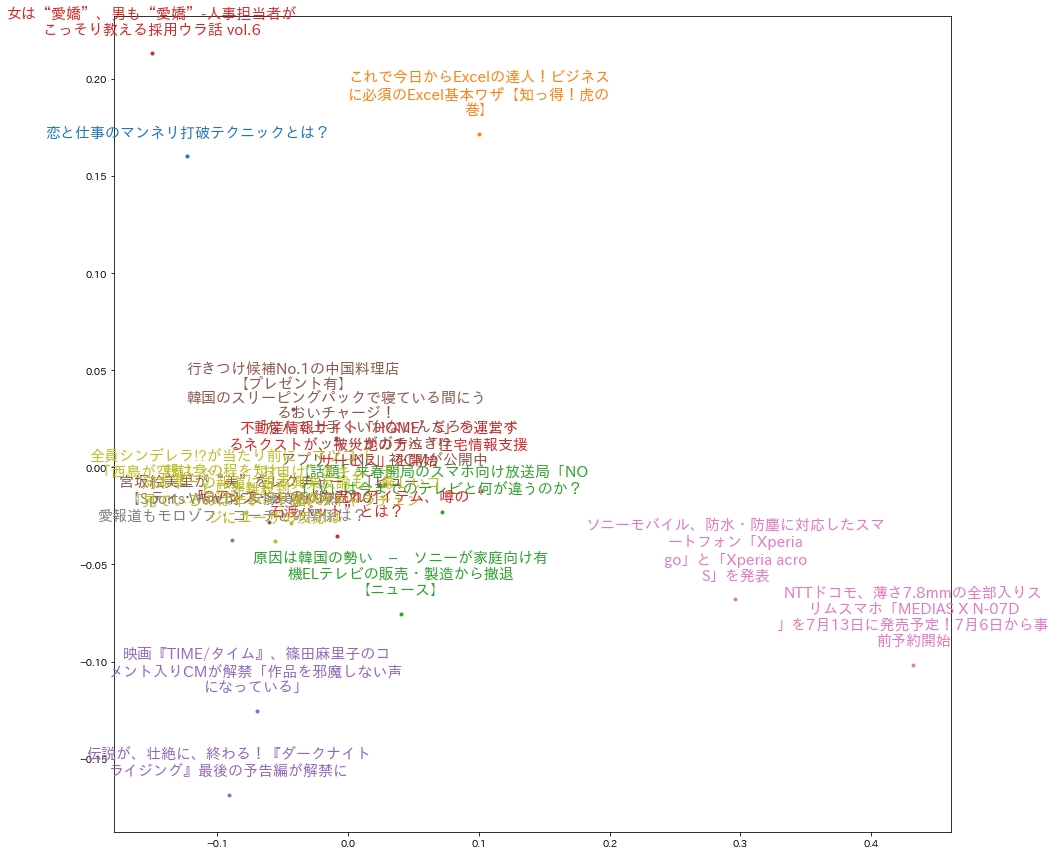

In [193]:
idx=random.sample(range(len(Y)),k=20)
plt.figure(figsize=(15, 15))
for i in np.unique(Y):
    cluster=np.intersect1d(np.where(Y==i)[0], idx)
    titles=[d['title'] for d in np.array(D)[cluster]]
#     samples=P[idx,:]
    plt.scatter(P[cluster, 0], P[cluster, 1], c=f'C{i}', label=VY.classes_[i], marker='.')
    
    for (x, y), title in zip(P[cluster, :], titles):
        title = '\n'.join(textwrap.wrap(title, 20))
        plt.annotate(title, (x, y+0.01), fontsize=15, fontweight='bold', c=f'C{i}', ha='center')
plt.show()

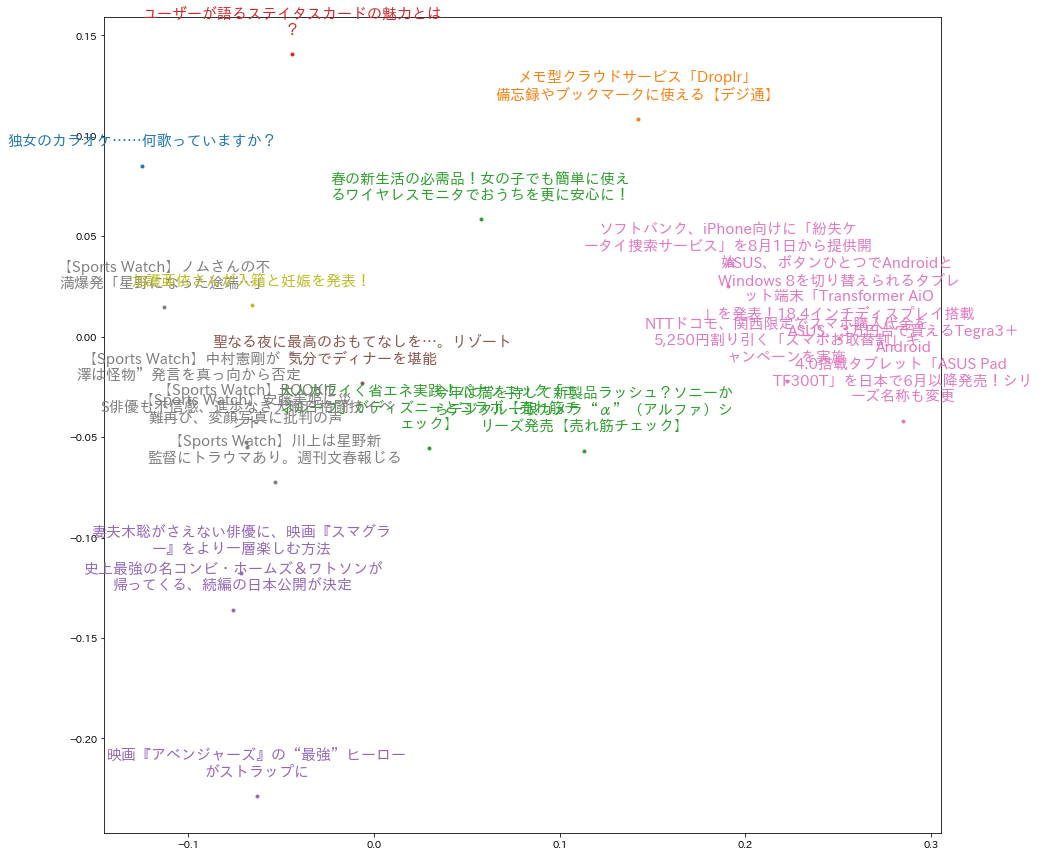

In [200]:
idx=random.sample(range(len(Y)),k=20)
plt.figure(figsize=(15, 15))
for i in np.unique(Y):
    cluster=np.intersect1d(np.where(Y==i)[0], idx)
    titles=[d['title'] for d in np.array(D)[cluster]]
#     samples=P[idx,:]
    plt.scatter(P[cluster, 0], P[cluster, 1], c=f'C{i}', label=VY.classes_[i], marker='.')
    
    for (x, y), title in zip(P[cluster, :], titles):
        title = '\n'.join(textwrap.wrap(title, 20))
        plt.annotate(title, (x, y+0.01), fontsize=15, fontweight='bold', c=f'C{i}', ha='center')
plt.show()

単語の相関の分析で示したように，第一主成分が大きいとガジェットなどの記事に，第二主成分が大きいと日常的な記事になっていることが分かる．

主成分分析をした結果，このデータセットではニュースが主に以下の３つの傾向で分類できそうだということが分かった．
- 恋愛やビジネスなどの日常的なトピック
- 家電やガジェットに関する記事
- 映画やスポーツなどのエンタメ記事

kmeansで元の単語ベクトルを3つに分類したところ，同じような分け方になることが確認できた

In [216]:
from sklearn.cluster import KMeans

In [218]:
model = KMeans(n_clusters=3)
model.fit(X)

KMeans(n_clusters=3)

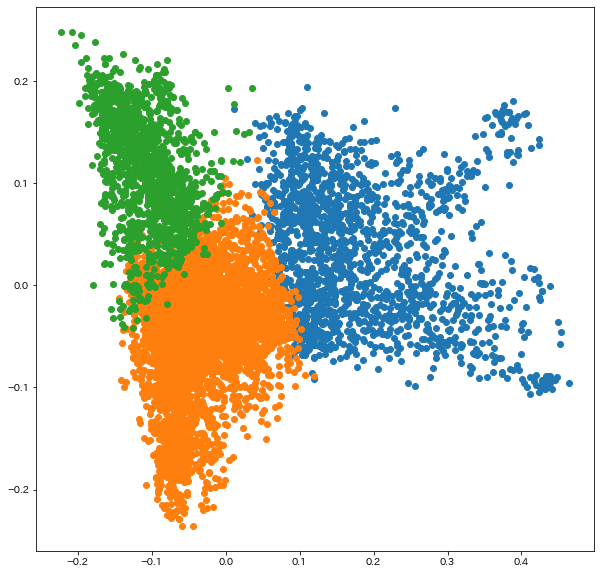

In [219]:
plt.figure(figsize=(10, 10))
for i in range(4):
    cluster=np.where(model.labels_==i)[0]
    plt.scatter(P[cluster, 0], P[cluster, 1], c=f'C{i}')